In [1]:
import tensorflow as tf
import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
sess = tf.Session()

In [3]:
save_file_name = os.path.join('temp', 'temp_spam_data.csv')

if not os.path.exists('temp'):
    os.makedirs('temp')
    
if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name, 'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/' \
              '00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x) >= 1]
    
    with open(save_file_name, 'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)
        
texts = [x[1] for x in text_data]
targets = [x[0] for x in text_data]

In [4]:
text_data[:2]

[['ham',
  'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'],
 ['ham', 'Ok lar... Joking wif u oni...']]

In [5]:
texts[:2]

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'Ok lar... Joking wif u oni...']

In [6]:
targets[:2]

['ham', 'ham']

In [7]:
# change spam's label to 1, ham's label to 0
target = [1 if x == 'spam' else 0 for x in targets]

In [8]:
target[:2]

[0, 0]

In [9]:
# normalize text
texts = [x.lower() for x in texts]
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
texts = [' '.join(x.split()) for x in texts]

In [10]:
texts[:2]

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni']

<function matplotlib.pyplot.show>

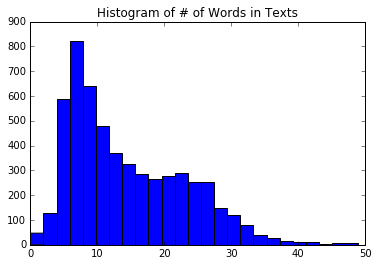

In [11]:
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 50]

plt.hist(text_lengths, bins=25)
plt.title('Histogram of # of Words in Texts')
plt.show

In [12]:
sentence_size = 40
min_word_freq = 3

In [13]:
vocab_processor = learn.preprocessing.VocabularyProcessor(
    sentence_size, min_frequency=min_word_freq)

vocab_processor.fit_transform(texts)
embedding_size = len(vocab_processor.vocabulary_)

In [14]:
embedding_size

2108

In [15]:
train_indices = np.random.choice(len(texts), round(len(texts)*0.8), replace=False)
test_indices = np.array(list(set(range(len(texts))) - set(train_indices)))

texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = [x for ix, x in enumerate(target) if ix in train_indices]
target_test = [x for ix, x in enumerate(target) if ix in test_indices]

In [16]:
identity_mat = tf.diag(tf.ones(shape=[embedding_size,]))

In [17]:
identity_mat

<tf.Tensor 'Diag:0' shape=(2108, 2108) dtype=float32>

In [18]:
# Variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[embedding_size, 1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

In [19]:
# Placeholders for input data
x_data = tf.placeholder(shape=[sentence_size], dtype=tf.int32)
y_target = tf.placeholder(shape=[1,1], dtype=tf.float32)

In [20]:
x_embed = tf.nn.embedding_lookup(identity_mat, x_data)
x_col_sums = tf.reduce_sum(x_embed, 0)

In [21]:
x_col_sums_2D = tf.expand_dims(x_col_sums, 0)
model_output = tf.add(tf.matmul(x_col_sums_2D, A), b)

In [22]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, targets=y_target))
predict = tf.sigmoid(model_output)

optimizer = tf.train.GradientDescentOptimizer(0.001)
train_step = optimizer.minimize(loss)

In [23]:
init = tf.global_variables_initializer()

In [24]:
sess.run(init)

In [25]:
losses = []
train_acc = []
train_acc_ave = []

In [26]:
for ix, t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [[target_train[ix]]]
    fd = {x_data: t, y_target:y_data}
    
    sess.run(train_step, feed_dict=fd)
    temp_loss = sess.run(loss, feed_dict=fd)
    losses.append(temp_loss)
    
    if (ix+1) % 10 == 0:
        print('Train Observation #'+str(ix+1)+': loss = '+str(temp_loss))
    
    [[temp_pred]] = sess.run(predict, feed_dict=fd)
    
    train_acc_temp = target_train[ix] == np.round(temp_pred)
    train_acc.append(train_acc_temp)
    if len(train_acc) >= 50:
        train_acc_ave.append(np.mean(train_acc[-50:]))
    

Train Observation #10: loss = 7.23739
Train Observation #20: loss = 0.182008
Train Observation #30: loss = 0.000897706
Train Observation #40: loss = 0.166723
Train Observation #50: loss = 9.55334e-06
Train Observation #60: loss = 0.308716
Train Observation #70: loss = 0.199991
Train Observation #80: loss = 2.52861e-06
Train Observation #90: loss = 1.11846
Train Observation #100: loss = 0.000600166
Train Observation #110: loss = 0.0239316
Train Observation #120: loss = 0.0321256
Train Observation #130: loss = 3.84802
Train Observation #140: loss = 0.836534
Train Observation #150: loss = 0.00141158
Train Observation #160: loss = 0.0132421
Train Observation #170: loss = 0.00445867
Train Observation #180: loss = 7.00551
Train Observation #190: loss = 0.000543977
Train Observation #200: loss = 7.76219
Train Observation #210: loss = 4.57832
Train Observation #220: loss = 0.00242458
Train Observation #230: loss = 2.77876e-05
Train Observation #240: loss = 0.0108576
Train Observation #250: los

In [27]:
test_acc = []

In [28]:
for ix, t in enumerate(vocab_processor.fit_transform(texts_test)):
    y_data = [[target_test[ix]]]
    fd = {x_data: t, y_target: y_data}
    
    if (ix + 1) % 50 == 0:
        print('Test Observation #{}'.format(ix + 1))
        
    [[temp_pred]] = sess.run(predict, feed_dict=fd)
    
    test_acc_temp = target_test[ix] == np.round(temp_pred)
    test_acc.append(test_acc_temp)
    
print()
print('Overall Test Accuracy: {}'.format(np.mean(test_acc)))

Test Observation #50
Test Observation #100
Test Observation #150
Test Observation #200
Test Observation #250
Test Observation #300
Test Observation #350
Test Observation #400
Test Observation #450
Test Observation #500
Test Observation #550
Test Observation #600
Test Observation #650
Test Observation #700
Test Observation #750
Test Observation #800
Test Observation #850
Test Observation #900
Test Observation #950
Test Observation #1000
Test Observation #1050
Test Observation #1100

Overall Test Accuracy: 0.7847533632286996
